In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

df_fake = pd.read_csv("/content/drive/MyDrive/news detection/Fake.csv")
df_real = pd.read_csv("/content/drive/MyDrive/news detection/True.csv")

df_fake['label'] = 0
df_real['label'] = 1

df = pd.concat([df_fake, df_real]).sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(str(text))
    tokens = [w.lower() for w in tokens if w.isalpha() and w.lower() not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

df['text_cleaned'] = df['text'].apply(preprocess)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

df['tokens'] = df['text_cleaned'].apply(word_tokenize)

w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=2, workers=4)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['text_cleaned'])
y = df['label']

In [7]:
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=5, random_state=42)
X_lsa = lsa.fit_transform(X_tfidf)

for i, comp in enumerate(lsa.components_):
    terms = [vectorizer.get_feature_names_out()[j] for j in comp.argsort()[-10:]]
    print(f"Topic {i+1}: {' | '.join(terms)}")

Topic 1: house | people | obama | clinton | would | state | republican | president | said | trump
Topic 2: woman | candidate | like | campaign | image | republican | donald | hillary | clinton | trump
Topic 3: donald | russian | missile | korean | russia | nuclear | china | north | korea | trump
Topic 4: legislation | vote | democrat | senator | committee | bill | house | senate | republican | tax
Topic 5: election | campaign | investigation | comey | fbi | email | russia | hillary | russian | clinton


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4710
           1       0.98      0.99      0.98      4270

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [1]:
!pip install --upgrade numpy
!pip uninstall -y gensim
!pip install gensim

ERROR: unknown command "install gensim" - maybe you meant "install"


In [5]:
!pip install gensim # remove the invisible character between install and gensim to run the command properly

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split


tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text_cleaned'])

sequences = tokenizer.texts_to_sequences(df['text_cleaned'])
padded = pad_sequences(sequences, maxlen=300)

# Now train_test_split is defined and can be used
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(padded, y, test_size=0.2)

model = Sequential([
    Embedding(5000, 64),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_dl, y_train_dl, epochs=2, validation_data=(X_test_dl, y_test_dl))

Epoch 1/2
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 212s 186ms/step - accuracy: 0.9150 - loss: 0.2130 - val_accuracy: 0.9697 - val_loss: 0.1041
Epoch 2/2
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 246s 172ms/step - accuracy: 0.9759 - loss: 0.0722 - val_accuracy: 0.9725 - val_loss: 0.0656


In [3]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load data and assign labels
# Update file paths to include the correct directory
df_fake = pd.read_csv("/content/drive/MyDrive/news detection/Fake.csv")
df_real = pd.read_csv("/content/drive/MyDrive/news detection/True.csv")

In [5]:
import pandas as pd

df_fake = pd.read_csv("/content/drive/MyDrive/news detection/Fake.csv")
df_real = pd.read_csv("/content/drive/MyDrive/news detection/True.csv")

df_fake['label'] = 0
df_real['label'] = 1

df = pd.concat([df_fake, df_real]).sample(frac=1, random_state=42).reset_index(drop=True)

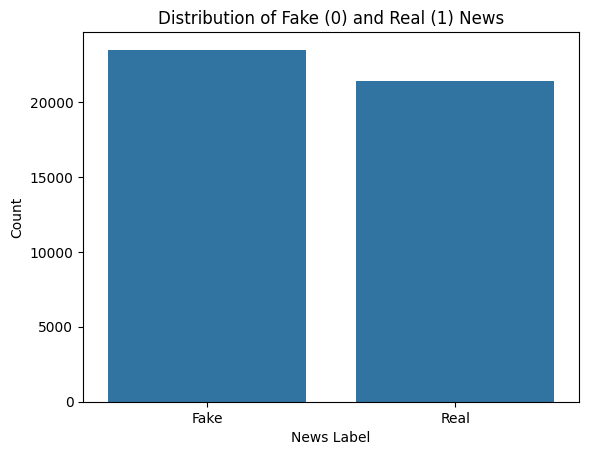

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of fake vs real
sns.countplot(x='label', data=df)
plt.title('Distribution of Fake (0) and Real (1) News')
plt.xlabel('News Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

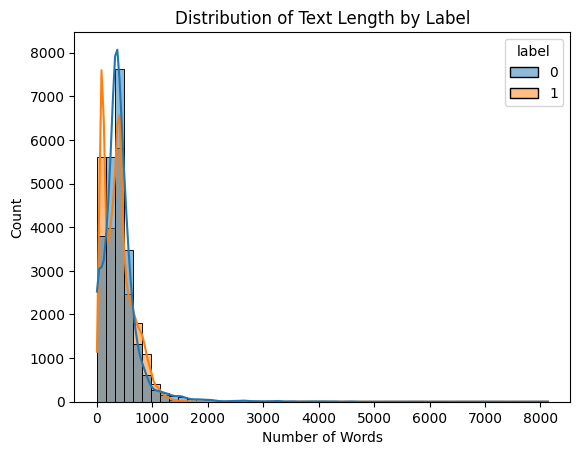

In [7]:
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Text Length by Label')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()
